In [1]:
import pandas as pd

df = pd.read_csv('../data/raw/btc_usdt_hourly.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
#drop columns
df = df.drop(columns=['UNIT', 'TIMESTAMP', 'TYPE', 'MARKET', 'INSTRUMENT', 'MAPPED_INSTRUMENT', 
                            'BASE', 'QUOTE', 'BASE_ID', 'QUOTE_ID', 'TRANSFORM_FUNCTION', 'FIRST_TRADE_TIMESTAMP', 
                            'LAST_TRADE_TIMESTAMP', 'HIGH_TRADE_TIMESTAMP', 'LOW_TRADE_TIMESTAMP','TOTAL_TRADES_UNKNOWN', 
                            'QUOTE_VOLUME_SELL', 'VOLUME_UNKNOWN', 'QUOTE_VOLUME_BUY', 'QUOTE_VOLUME_UNKNOWN',
                            'QUOTE_VOLUME', 'FIRST_TRADE_PRICE','HIGH_TRADE_PRICE', 'LOW_TRADE_PRICE', 'LAST_TRADE_PRICE'])
print(df.columns)


Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TOTAL_TRADES', 'TOTAL_TRADES_BUY',
       'TOTAL_TRADES_SELL', 'VOLUME', 'VOLUME_BUY', 'VOLUME_SELL'],
      dtype='object')


In [2]:
import pandas as pd
import numpy as np

# ------------------------------
# 1. Compute Returns
# ------------------------------
# Percentage returns based on CLOSE prices
df['return'] = df['CLOSE'].pct_change()
# Log returns
df['log_return'] = np.log(df['CLOSE'] / df['CLOSE'].shift(1))

# ------------------------------
# 2. Compute Hourly Volatility
# ------------------------------
# Estimate volatility as the rolling standard deviation of returns (e.g., over a 12-hour window)
vol_window = 12
df['hourly_volatility'] = df['return'].rolling(window=vol_window).std()

# ------------------------------
# 3. Technical Indicators
# ------------------------------

# 3.1. 8-13-21 EMA Strategy
# Compute the 8-, 13-, and 21-period exponential moving averages.
df['EMA_8'] = df['CLOSE'].ewm(span=8, adjust=False).mean()
df['EMA_13'] = df['CLOSE'].ewm(span=13, adjust=False).mean()
df['EMA_21'] = df['CLOSE'].ewm(span=21, adjust=False).mean()
# Create a simple signal: bullish (1) when EMA_8 is above both EMA_13 and EMA_21,
# bearish (-1) when EMA_8 is below both, else neutral (0)
df['EMA_signal'] = np.where((df['EMA_8'] > df['EMA_13']) & (df['EMA_8'] > df['EMA_21']), 1,
                     np.where((df['EMA_8'] < df['EMA_13']) & (df['EMA_8'] < df['EMA_21']), -1, 0))

# 3.2. Moving Average Convergence Divergence (MACD)
# Standard MACD parameters: 12-period EMA, 26-period EMA, and a 9-period Signal Line.
short_window = 12
long_window = 26
signal_window = 9
df['EMA_short'] = df['CLOSE'].ewm(span=short_window, adjust=False).mean()
df['EMA_long'] = df['CLOSE'].ewm(span=long_window, adjust=False).mean()
df['MACD'] = df['EMA_short'] - df['EMA_long']
df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
# MACD Histogram (difference between MACD and its signal line)
df['MACD_Hist'] = df['MACD'] - df['Signal_Line']

# 3.3. Bollinger Bands
# Calculate a 20-period simple moving average and standard deviation.
df['SMA20'] = df['CLOSE'].rolling(window=20).mean()
df['STD20'] = df['CLOSE'].rolling(window=20).std()
df['Upper_BB'] = df['SMA20'] + (2 * df['STD20'])
df['Lower_BB'] = df['SMA20'] - (2 * df['STD20'])

# 3.4. RSI Momentum
# Compute the Relative Strength Index (RSI) using a 14-period window.
delta = df['CLOSE'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14, min_periods=14).mean()
avg_loss = loss.rolling(window=14, min_periods=14).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# ------------------------------
# 4. Display a Sample of the Results
# ------------------------------
cols_to_display = ['CLOSE', 'return', 'hourly_volatility',
                   'EMA_8', 'EMA_13', 'EMA_21', 'EMA_signal',
                   'MACD', 'Signal_Line', 'MACD_Hist',
                   'SMA20', 'Upper_BB', 'Lower_BB',
                   'RSI_14']

print(df[cols_to_display].tail())


                              CLOSE    return  hourly_volatility  \
datetime                                                           
2025-03-03 14:00:00+00:00  89278.88 -0.046032           0.015511   
2025-03-03 15:00:00+00:00  90035.37  0.008473           0.015852   
2025-03-03 16:00:00+00:00  90154.00  0.001318           0.015844   
2025-03-03 17:00:00+00:00  90300.01  0.001620           0.015725   
2025-03-03 18:00:00+00:00  87132.80 -0.035074           0.017853   

                                  EMA_8        EMA_13        EMA_21  \
datetime                                                              
2025-03-03 14:00:00+00:00  92007.261775  92106.818391  91751.986322   
2025-03-03 15:00:00+00:00  91569.063603  91810.897192  91595.930293   
2025-03-03 16:00:00+00:00  91254.605025  91574.197594  91464.845721   
2025-03-03 17:00:00+00:00  91042.472797  91392.170794  91358.951564   
2025-03-03 18:00:00+00:00  90173.656620  90783.689252  90974.755967   

                         

First 5 rows of the dataset:
                               OPEN      HIGH       LOW     CLOSE  \
datetime                                                            
2024-02-22 19:00:00+00:00  51718.81  51718.82  51460.80  51509.99   
2024-02-22 20:00:00+00:00  51509.99  52065.78  51461.10  51995.58   
2024-02-22 21:00:00+00:00  51995.58  52007.65  51545.26  51656.96   
2024-02-22 22:00:00+00:00  51656.96  51717.87  51184.04  51456.01   
2024-02-22 23:00:00+00:00  51456.01  51482.69  51230.00  51288.42   

                           TOTAL_TRADES  TOTAL_TRADES_BUY  TOTAL_TRADES_SELL  \
datetime                                                                       
2024-02-22 19:00:00+00:00         50652             27901              22751   
2024-02-22 20:00:00+00:00        108926             71626              37300   
2024-02-22 21:00:00+00:00         54274             25981              28293   
2024-02-22 22:00:00+00:00         73657             24349              49308   
2024-02

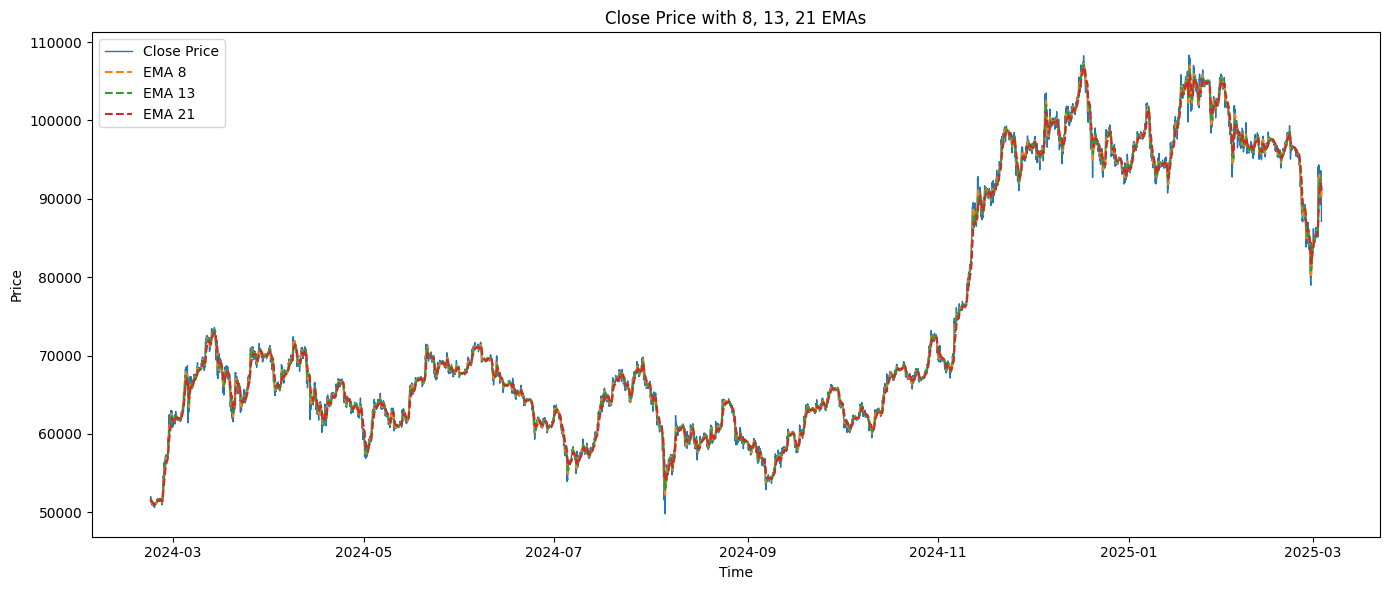

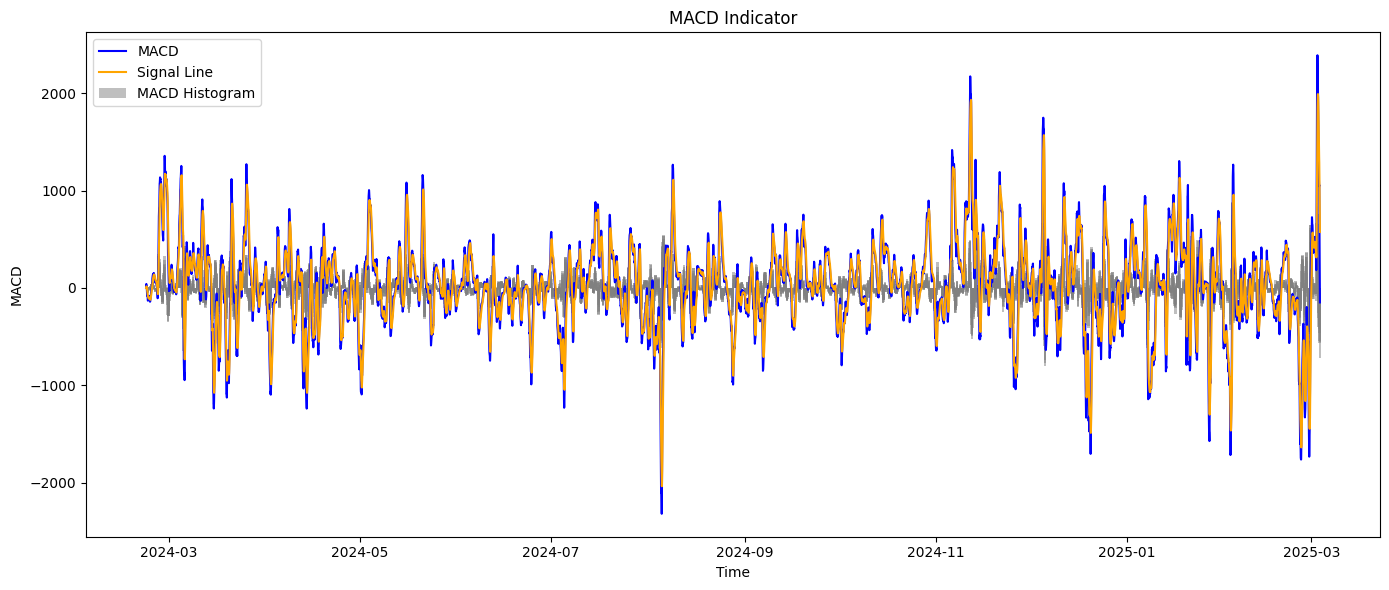

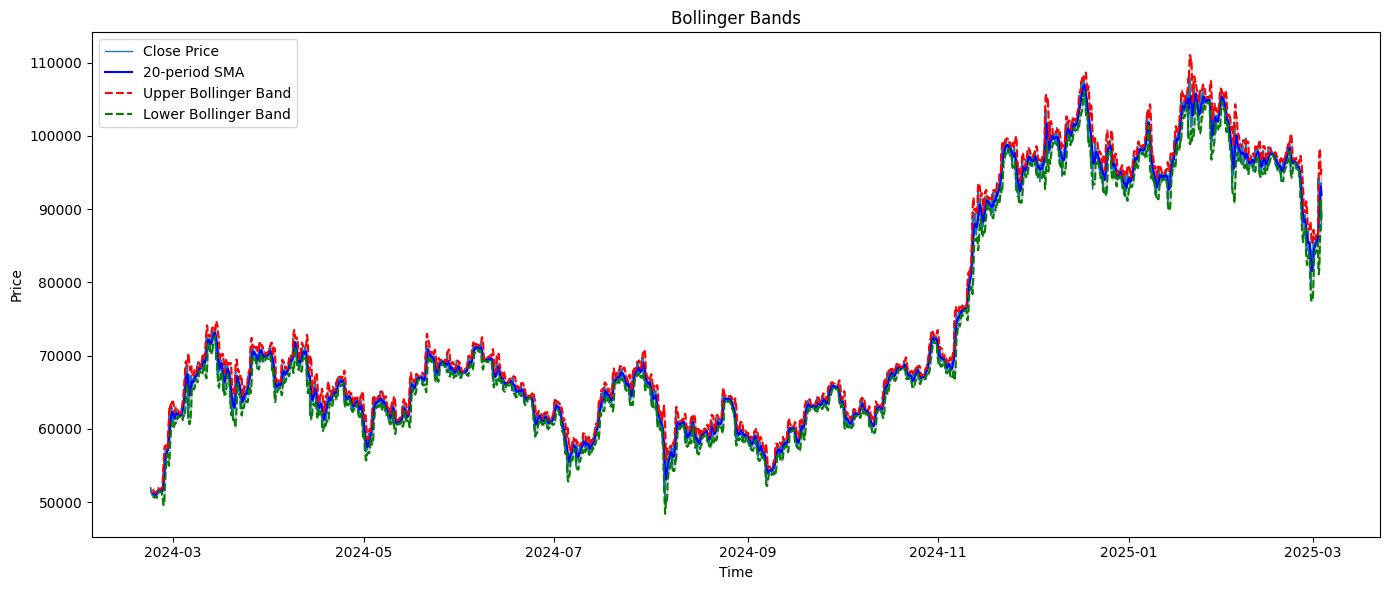

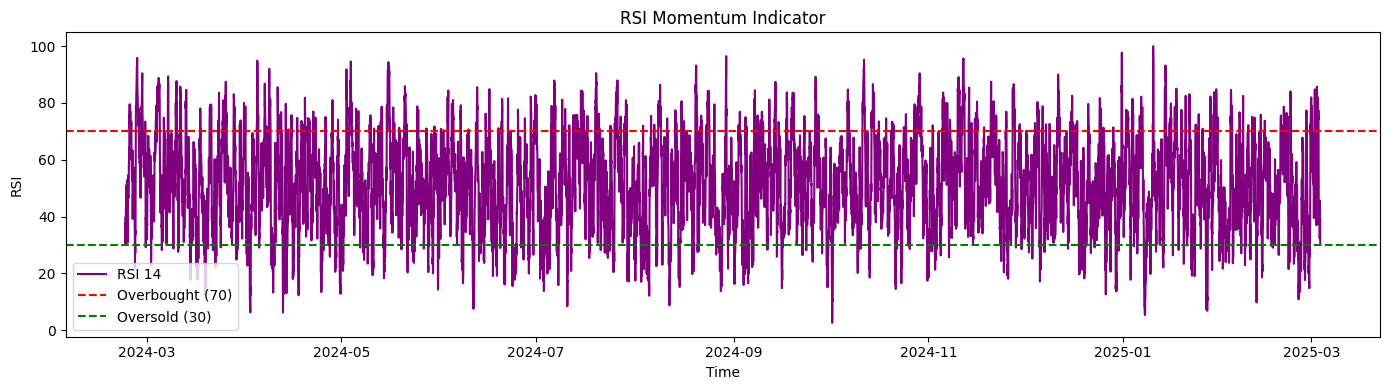

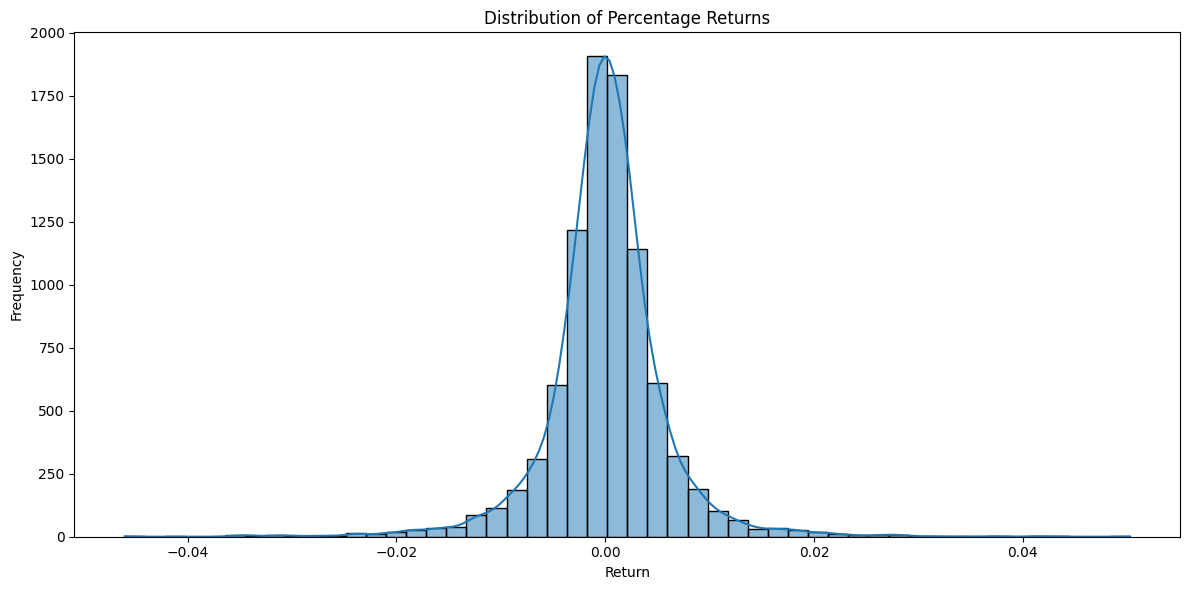

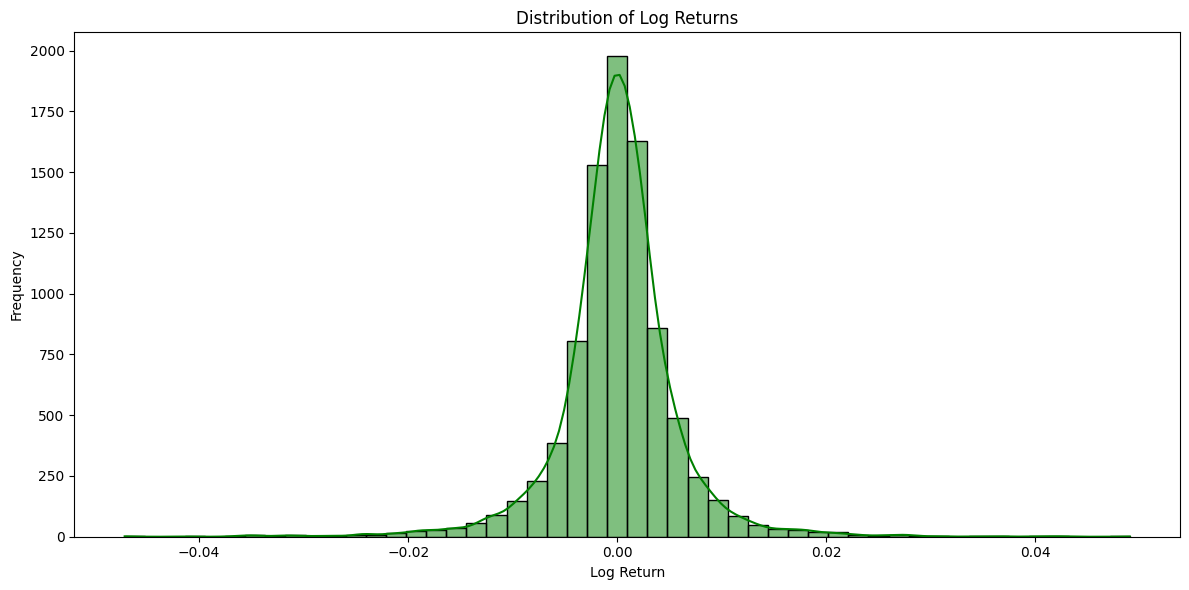

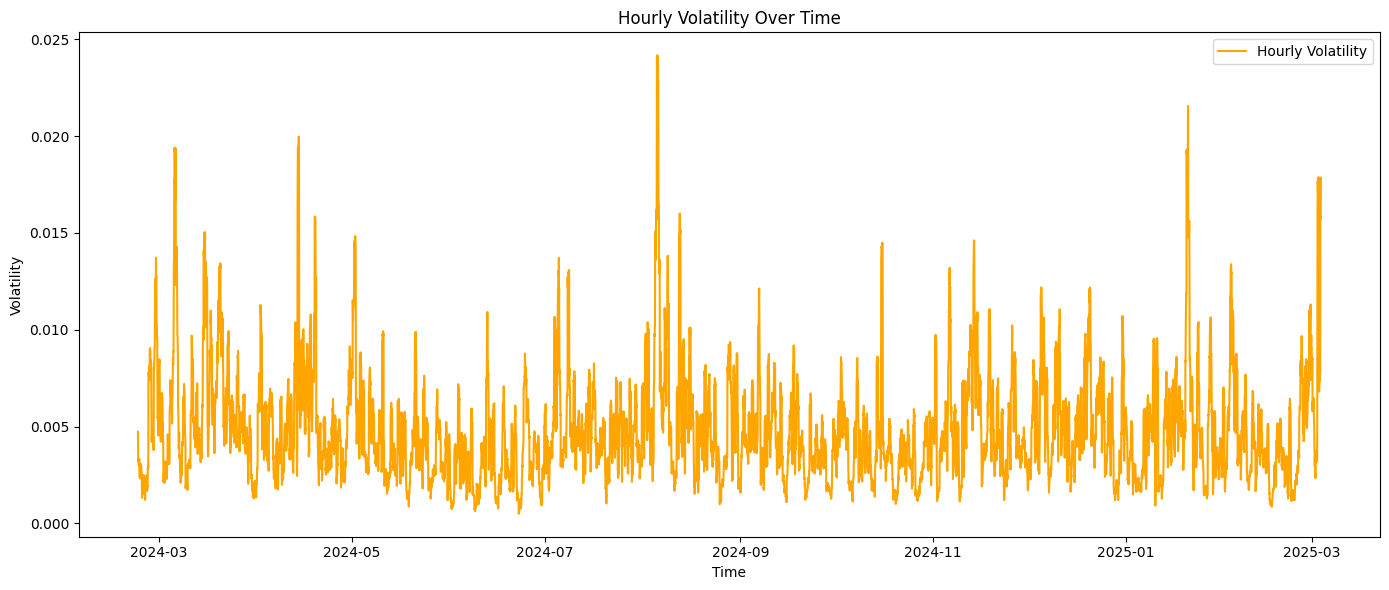

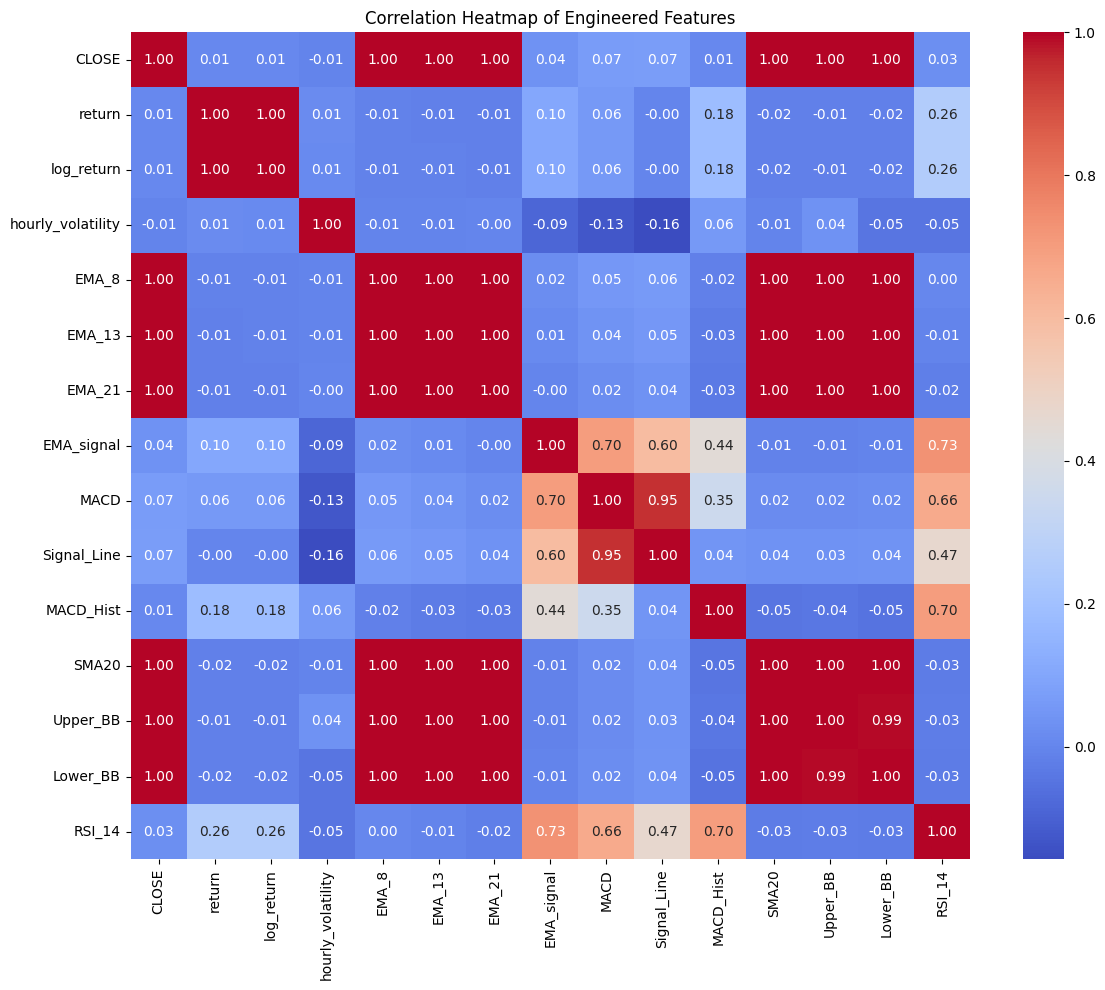

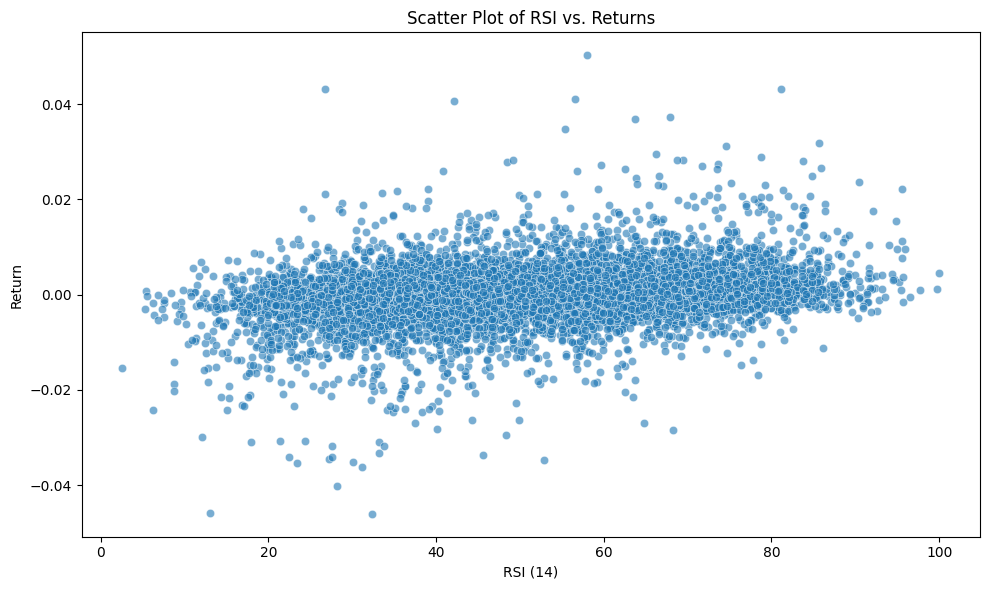

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Basic Information & Summary
print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset shape:", df.shape)
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nSummary Statistics:")
print(df.describe())

# 2. Time Series Plots: Price and EMAs
plt.figure(figsize=(14,6))
plt.plot(df.index, df['CLOSE'], label="Close Price", linewidth=1)
plt.plot(df.index, df['EMA_8'], label="EMA 8", linestyle="--")
plt.plot(df.index, df['EMA_13'], label="EMA 13", linestyle="--")
plt.plot(df.index, df['EMA_21'], label="EMA 21", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Close Price with 8, 13, 21 EMAs")
plt.legend()
plt.tight_layout()
plt.show()

# 3. MACD Visualization
plt.figure(figsize=(14,6))
plt.plot(df.index, df['MACD'], label="MACD", color="blue")
plt.plot(df.index, df['Signal_Line'], label="Signal Line", color="orange")
plt.bar(df.index, df['MACD_Hist'], label="MACD Histogram", color="gray", alpha=0.5)
plt.xlabel("Time")
plt.ylabel("MACD")
plt.title("MACD Indicator")
plt.legend()
plt.tight_layout()
plt.show()

# 4. Bollinger Bands Plot
plt.figure(figsize=(14,6))
plt.plot(df.index, df['CLOSE'], label="Close Price", linewidth=1)
plt.plot(df.index, df['SMA20'], label="20-period SMA", color="blue")
plt.plot(df.index, df['Upper_BB'], label="Upper Bollinger Band", color="red", linestyle="--")
plt.plot(df.index, df['Lower_BB'], label="Lower Bollinger Band", color="green", linestyle="--")
plt.fill_between(df.index, df['Lower_BB'], df['Upper_BB'], color="gray", alpha=0.3)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Bollinger Bands")
plt.legend()
plt.tight_layout()
plt.show()

# 5. RSI Plot
plt.figure(figsize=(14,4))
plt.plot(df.index, df['RSI_14'], label="RSI 14", color="purple")
plt.axhline(70, linestyle="--", color="red", label="Overbought (70)")
plt.axhline(30, linestyle="--", color="green", label="Oversold (30)")
plt.xlabel("Time")
plt.ylabel("RSI")
plt.title("RSI Momentum Indicator")
plt.legend()
plt.tight_layout()
plt.show()

# 6. Distribution of Returns and Log Returns
plt.figure(figsize=(12,6))
sns.histplot(df['return'].dropna(), bins=50, kde=True)
plt.title("Distribution of Percentage Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(df['log_return'].dropna(), bins=50, kde=True, color="green")
plt.title("Distribution of Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 7. Hourly Volatility Over Time
plt.figure(figsize=(14,6))
plt.plot(df.index, df['hourly_volatility'], label="Hourly Volatility", color="orange")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.title("Hourly Volatility Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# 8. Correlation Analysis among Features
features = ['CLOSE', 'return', 'log_return', 'hourly_volatility',
            'EMA_8', 'EMA_13', 'EMA_21', 'EMA_signal',
            'MACD', 'Signal_Line', 'MACD_Hist',
            'SMA20', 'Upper_BB', 'Lower_BB', 'RSI_14']
corr_matrix = df[features].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Engineered Features")
plt.tight_layout()
plt.show()

# 9. Additional Scatter Plot: RSI vs. Returns
plt.figure(figsize=(10,6))
sns.scatterplot(x='RSI_14', y='return', data=df, alpha=0.6)
plt.title("Scatter Plot of RSI vs. Returns")
plt.xlabel("RSI (14)")
plt.ylabel("Return")
plt.tight_layout()
plt.show()


In [4]:
df.to_csv('../data/processed/btc_usdt_hourly_processed.csv', index=True)
print("Data processing and feature engineering completed and saved")
print(df.columns)

Data processing and feature engineering completed and saved
Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TOTAL_TRADES', 'TOTAL_TRADES_BUY',
       'TOTAL_TRADES_SELL', 'VOLUME', 'VOLUME_BUY', 'VOLUME_SELL', 'return',
       'log_return', 'hourly_volatility', 'EMA_8', 'EMA_13', 'EMA_21',
       'EMA_signal', 'EMA_short', 'EMA_long', 'MACD', 'Signal_Line',
       'MACD_Hist', 'SMA20', 'STD20', 'Upper_BB', 'Lower_BB', 'RSI_14'],
      dtype='object')
